# Understanding cloud organization with MaskRCNN using Keras/Tensorflow

In [2]:
import os
import gc
import sys
import time
import json
import glob
import random
from pathlib import Path
import pandas as pd

from PIL import Image
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa

import itertools
from tqdm import tqdm

In [3]:
train_df = pd.read_csv("./understanding_cloud_organization/train.csv")
train_df = train_df.dropna()

In [4]:
train_df.head()

Image_Label                                      EncodedPixels
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...
5  002be4f.jpg_Flower  1339279 519 1340679 519 1342079 519 1343479 51...
7   002be4f.jpg_Sugar  67495 350 68895 350 70295 350 71695 350 73095 ...

In [5]:
category_list = ["Fish","Flower","Gravel","Sugar"]

In [6]:
#Reformat dataframe for further processing steps 
train_dict = {}
train_class_dict = {}
for idx, row in train_df.iterrows():
    image_filename = row.Image_Label.split("_")[0]
    class_name = row.Image_Label.split("_")[1]
    class_id = category_list.index(class_name)
    if train_dict.get(image_filename):
        train_dict[image_filename].append(row.EncodedPixels)
        train_class_dict[image_filename].append(class_id)
    else:
        train_dict[image_filename] = [row.EncodedPixels]
        train_class_dict[image_filename] = [class_id]

In [8]:
df = pd.DataFrame(columns=["image_id","EncodedPixels","CategoryId","Width","Height"])
for key, value in train_dict.items():
    img = Image.open("./understanding_cloud_organization/train_images/{}".format(key))
    width, height = img.width, img.height
    df = df.append({"image_id": key, "EncodedPixels": value, "CategoryId": train_class_dict[key], "Width": width, "Height": height},ignore_index=True)

In [9]:
df.head()

image_id                                      EncodedPixels CategoryId  \
0  0011165.jpg  [264918 937 266318 937 267718 937 269118 937 2...     [0, 1]   
1  002be4f.jpg  [233813 878 235213 878 236613 878 238010 881 2...  [0, 1, 3]   
2  0031ae9.jpg  [3510 690 4910 690 6310 690 7710 690 9110 690 ...  [0, 1, 3]   
3  0035239.jpg  [100812 462 102212 462 103612 462 105012 462 1...     [1, 2]   
4  003994e.jpg  [2367966 18 2367985 2 2367993 8 2368002 62 236...  [0, 2, 3]   

  Width Height  
0  2100   1400  
1  2100   1400  
2  2100   1400  
3  2100   1400  
4  2100   1400

# MaskRCNN Setup 

In [10]:
NUM_CATS = len(category_list)
IMAGE_SIZE = 512

In [9]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

!rm -rf .git # to prevent an error when the kernel is committed
!rm -rf images assets # to prevent displaying images at the bottom of a kernel

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.90 MiB | 27.01 MiB/s, done.
Resolving deltas: 100% (571/571), done.


In [11]:
sys.path.append('./Mask_RCNN')
from mrcnn.config import Config

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [21]:
#Download COCO weights as a pretrained model 
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'

-rw-r--r--  1 prerna  staff   246M Nov 25  2017 mask_rcnn_coco.h5


In [12]:
#Create model config file 
class CloudConfig(Config):
    NAME = "cloud"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4 #That is the maximum with the memory available on kernels
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    
    # STEPS_PER_EPOCH should be the number of instances 
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    STEPS_PER_EPOCH = 4500
    VALIDATION_STEPS = 500
    
config = CloudConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [13]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

In [14]:
#Cloud Config Class - contains all utilities to run model seamlessly and visualise masks 
class CloudDataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(category_list):
            self.add_class("cloud", i+1, name)
        
        # Add images 
        for i, row in df.iterrows():
            self.add_image("cloud", 
                           image_id=row.name, 
                           path='./understanding_cloud_organization/train_images/'+str(row.image_id), 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [category_list[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

('./understanding_cloud_organization/train_images/d819d94.jpg', ['Fish', 'Flower'])


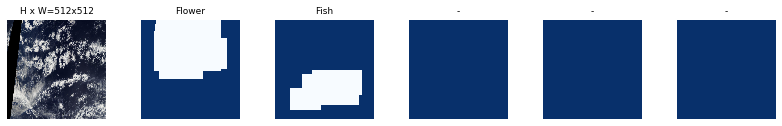

('./understanding_cloud_organization/train_images/d9b3608.jpg', ['Flower', 'Sugar'])


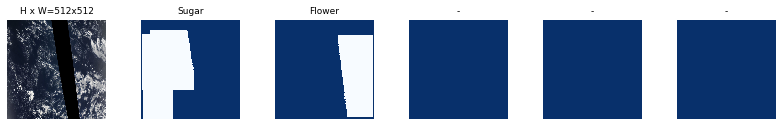

('./understanding_cloud_organization/train_images/26bd626.jpg', ['Fish', 'Flower', 'Sugar'])


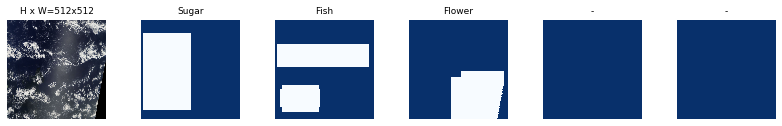

('./understanding_cloud_organization/train_images/2bd2f34.jpg', ['Gravel', 'Sugar'])


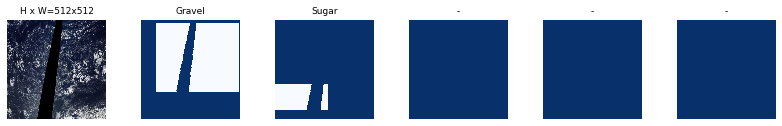

('./understanding_cloud_organization/train_images/8d9792f.jpg', ['Flower'])


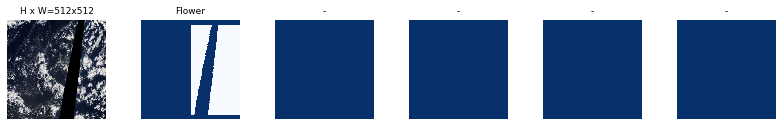

In [15]:
training_percentage = 0.9 #(90% training,10% validation)

training_set_size = int(training_percentage*len(df))
validation_set_size = int((1-training_percentage)*len(df))

train_dataset = CloudDataset(df[:training_set_size])
train_dataset.prepare()

valid_dataset = CloudDataset(df[training_set_size:training_set_size+validation_set_size])
valid_dataset.prepare()

#VIsualise image masks 
for i in range(5):
    image_id = random.choice(train_dataset.image_ids)
    print(train_dataset.image_reference(image_id))
    
    image = train_dataset.load_image(image_id)
    mask, class_ids = train_dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, train_dataset.class_names, limit=5)

# Training model 

In [16]:
LR = 1e-4
EPOCHS = [3,4]

import warnings 
warnings.filterwarnings("ignore")

In [17]:
#Applying augmentation to make classification more effective 
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5)
], random_order=True)

In [22]:
#initialize the model with the COCO weights 
model = modellib.MaskRCNN(mode='training', config=config, model_dir=".")

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    'mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

We will first train the heads before training the entire model.

In [19]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR*2,
            epochs=EPOCHS[0],
            layers='heads',
            augmentation=None)

history = model.keras_model.history.history


Starting at epoch 0. LR=0.0002

Checkpoint Path: ../../working/cloud20190827T2331/mask_rcnn_cloud_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (

In [20]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR,
            epochs=EPOCHS[1],
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 3. LR=0.0001

Checkpoint Path: ../../working/cloud20190827T2331/mask_rcnn_cloud_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (

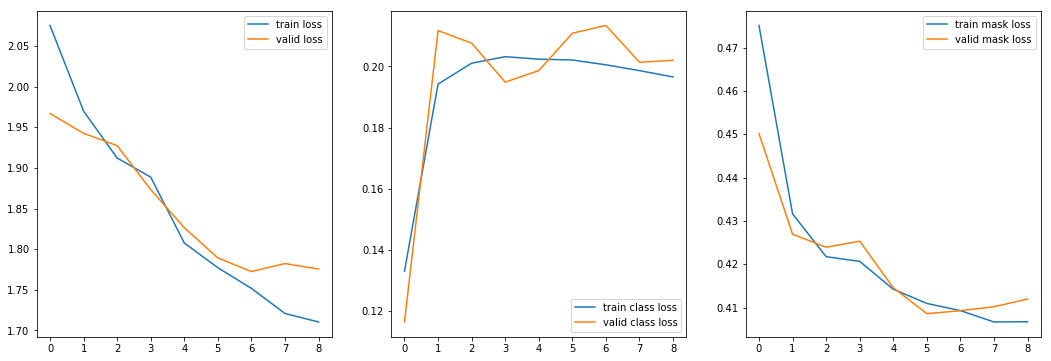

In [21]:
epochs = range(EPOCHS[-1])

plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history['mrcnn_class_loss'], label="train class loss")
plt.plot(epochs, history['val_mrcnn_class_loss'], label="valid class loss")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history['mrcnn_mask_loss'], label="train mask loss")
plt.plot(epochs, history['val_mrcnn_mask_loss'], label="valid mask loss")
plt.legend()

plt.show()

In [22]:
best_epoch = np.argmin(history["val_loss"]) + 1
print("Best epoch: ", best_epoch)
print("Valid loss: ", history["val_loss"][best_epoch-1])

Best epoch:  7
Valid loss:  1.772538774728775


# Load the best weights and visual assessment on small sample

In [23]:
class InferenceConfig(CloudConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

In [25]:
# Fix overlapping masks
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

In [27]:
test_df = pd.DataFrame(columns=["image_id","EncodedPixels","CategoryId"])
for idx,row in sample_df.iterrows():
    image_filename = row.Image_Label.split("_")[0]
    test_df = test_df.append({"image_id": image_filename},ignore_index=True)
test_df = test_df.drop_duplicates()

../../input/understanding_cloud_organization/test_images/2c0ac34.jpg


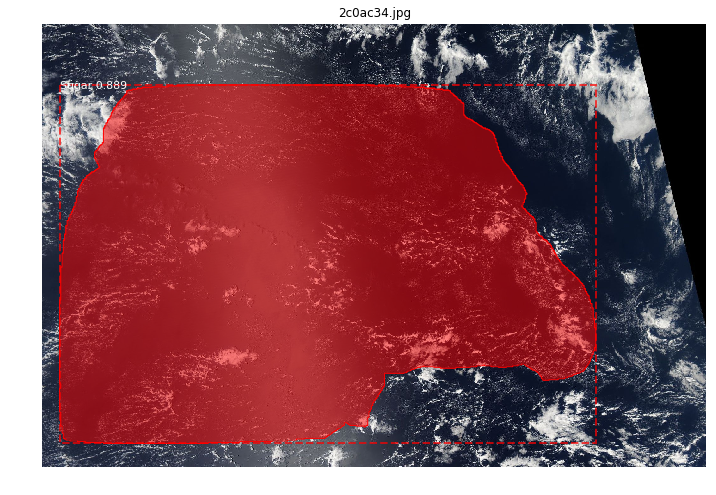

../../input/understanding_cloud_organization/test_images/1091c21.jpg


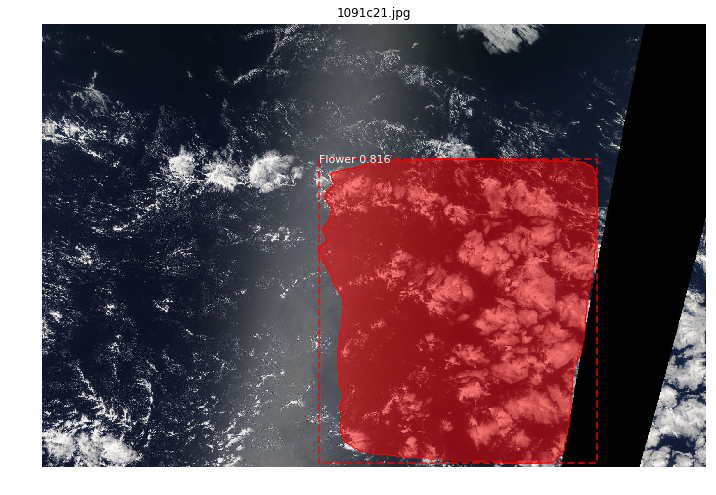

../../input/understanding_cloud_organization/test_images/04022ad.jpg


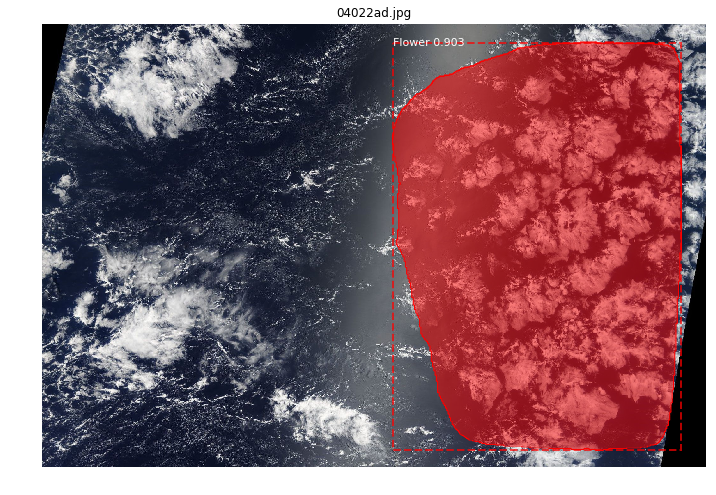

../../input/understanding_cloud_organization/test_images/cc3d871.jpg


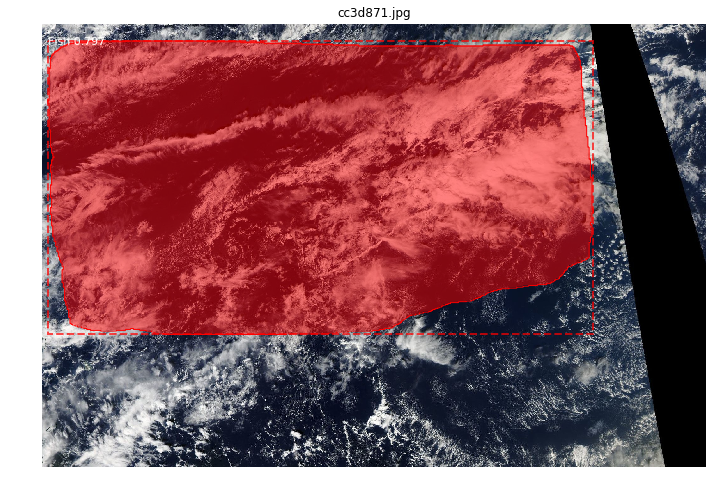

../../input/understanding_cloud_organization/test_images/b020d9e.jpg


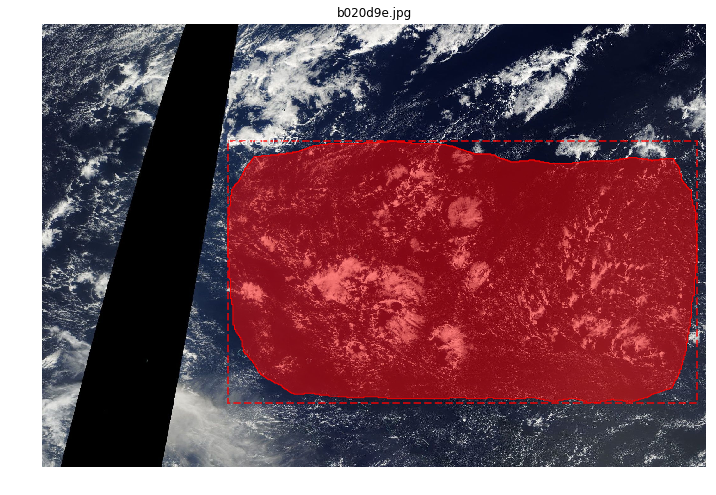

../../input/understanding_cloud_organization/test_images/e20790b.jpg


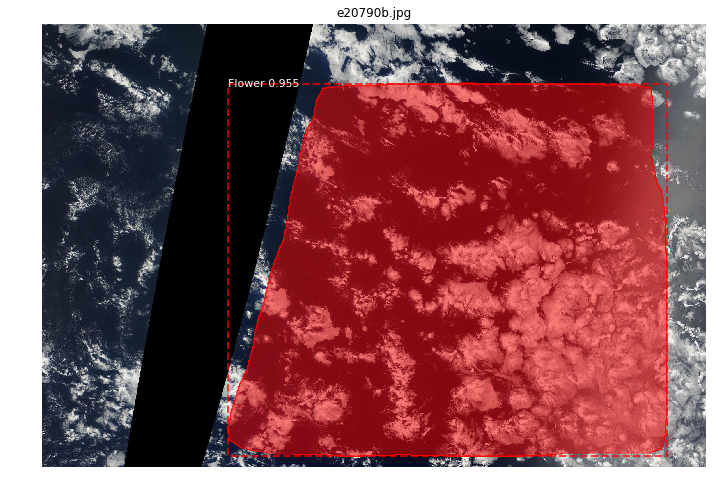

../../input/understanding_cloud_organization/test_images/c521501.jpg


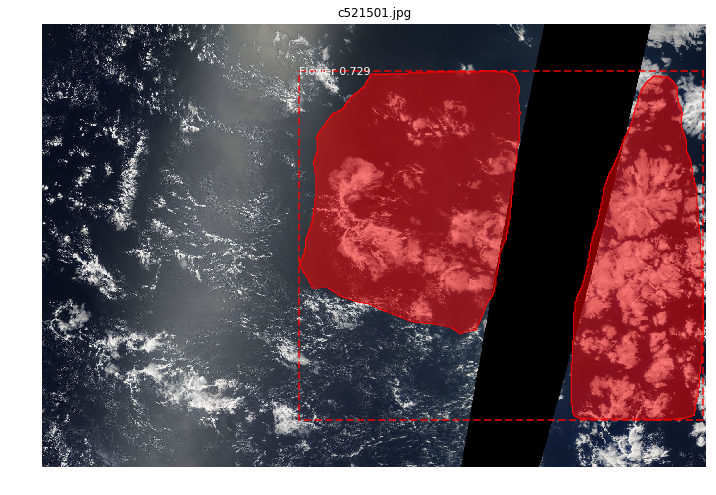

../../input/understanding_cloud_organization/test_images/cf1605a.jpg


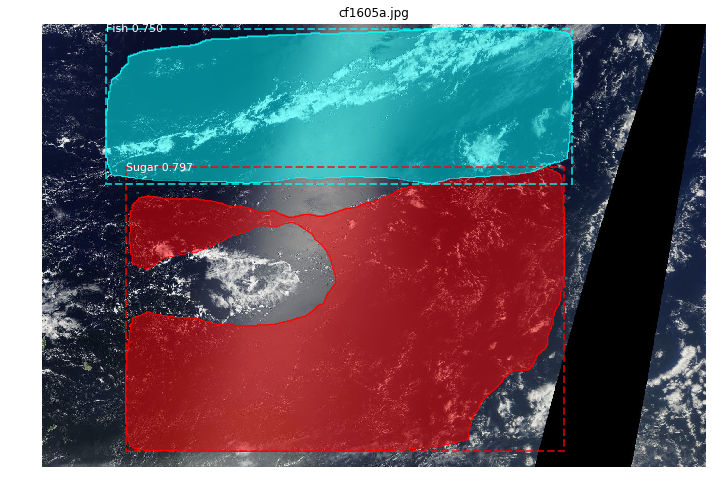

In [29]:
for i in range(8):
    image_id = test_df.sample()["image_id"].values[0]
    image_path = str('./understanding_cloud_organization/test_images/'+image_id)
    print(image_path)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = model.detect([resize_image(image_path)])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
        
    visualize.display_instances(img, rois, masks, r['class_ids'], 
                                ['bg']+category_list, r['scores'],
                                title=image_id, figsize=(12, 12))

# Prediction submission

In [30]:
#Define rle encoder for 
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join([str(x) for x in run_lengths])

In [31]:
submission_df = sample_df.copy()
submission_df["EncodedPixels"] = ""
with tqdm(total=len(test_df)) as pbar:
    for i,row in test_df.iterrows():
        pbar.update(1)
        image_id = row["image_id"]
        image_path = str('../../input/understanding_cloud_organization/test_images/'+image_id)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        result = model.detect([resize_image(image_path)])
        r = result[0]

        if r['masks'].size > 0:
            masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
            for m in range(r['masks'].shape[-1]):
                masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                            (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

            y_scale = img.shape[0]/IMAGE_SIZE
            x_scale = img.shape[1]/IMAGE_SIZE
            rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
            masks, rois, class_ids = r['masks'], r['rois'], r['class_ids']

            #The following piece of code is creating rectangular masks from
            # the ROIs instead of using the masks drawn by the MaskRCNN.
            # It also removes any missing area from the imagery from the predicted masks.
            # Everything is added directly to the submission dataframe.
            rectangular_masks = []
            mask_dict = {"Fish":[],"Flower":[],"Gravel":[],"Sugar":[]}
            for roi, class_id in zip(rois, class_ids):
                rectangular_mask = np.zeros((512,512))
                rectangular_mask[roi[0]:roi[2], roi[1]:roi[3]] = 255
                img = cv2.resize(img, dsize=(512,512), interpolation = cv2.INTER_LINEAR)
                cropped_img = img[roi[0]:roi[2], roi[1]:roi[3]]
                
                kernel = np.ones((5,5),np.uint8)
                missing_data = np.where(cropped_img[:,:,0]==0,255,0).astype('uint8')
                contour_mask = np.zeros(missing_data.shape)
                opening = cv2.morphologyEx(missing_data.astype('uint8'), cv2.MORPH_OPEN, kernel)
                contours= cv2.findContours(opening,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
                if len(contours[0])>0:
                    largest_contour = max(contours[0], key = cv2.contourArea)
                    cv2.fillPoly(contour_mask, pts =[largest_contour], color=(255))
                    kernel = np.ones((5,5),np.uint8)
                    opening = cv2.morphologyEx(contour_mask, cv2.MORPH_OPEN, kernel)
                    fixed_mask = np.where(opening[:,:]==255,0,255)
                    rectangular_mask[roi[0]:roi[2], roi[1]:roi[3]] = fixed_mask.copy()
                    
                if mask_dict[category_list[class_id-1]]==[]:
                    mask_dict[category_list[class_id-1]] = rectangular_mask
                else:
                    previous_mask = mask_dict[category_list[class_id-1]].copy()
                    #prevents a bug where the mask is in int64
                    previous_mask = previous_mask.astype('float64')
                    boolean_mask = np.ma.mask_or(previous_mask, rectangular_mask)
                    merged_mask = np.where(boolean_mask, 255, 0)
                    mask_dict[category_list[class_id-1]] = merged_mask

            
            #Going through the masks per category and create a md mask in RLE
            for cloud_category in mask_dict.keys():
                if mask_dict[cloud_category]!=[]:
                    #resizing for submission
                    resized_mask = cv2.resize((mask_dict[cloud_category]/255).astype('uint8'), dsize=(525,350), interpolation = cv2.INTER_LINEAR)
                    rle_str = rle_encoding(resized_mask)
                    image_label = "{}_{}".format(image_id,cloud_category)
                    submission_df.loc[submission_df['Image_Label']==image_label,'EncodedPixels'] = rle_str
        else:
            masks, rois = r['masks'], r['rois']

100%|██████████| 3698/3698 [15:19<00:00,  4.14it/s]


In [32]:
submission_df.query("EncodedPixels!=''").head()

Image_Label                                      EncodedPixels
2   002f507.jpg_Gravel  13 296 363 296 713 296 1063 296 1413 296 1763 ...
11   0038327.jpg_Sugar  4334 2 4337 1 4339 7 4347 4 4352 7 4360 1 4362...
13  004f759.jpg_Flower  87522 171 87872 171 88222 171 88572 171 88922 ...
18  005ba08.jpg_Gravel  19253 1 19255 5 19261 1 19266 1 19268 7 19276 ...
20    006440a.jpg_Fish  29751 115 30101 115 30451 115 30801 115 31151 ...

In [33]:
submission_df.to_csv("./submission.csv",index=False)